# 基于机器学习可解释性分析的信贷预测案例研究

In [43]:
# !pip install imbalanced-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\UserFiles\Anaconda3\envs\hh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  

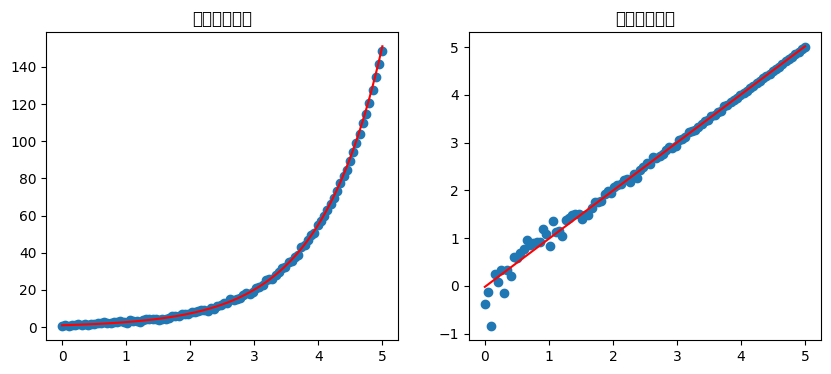

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 生成模拟数据
x = np.linspace(0, 5, 100)
y = np.exp(x) + np.random.normal(0, 0.5, 100)  # 指数关系+噪声

# 对数变换
log_y = np.log(y)

# 建模
model = LinearRegression()
model.fit(x.reshape(-1,1), log_y)
pred_log_y = model.predict(x.reshape(-1,1))
pred_y = np.exp(pred_log_y)  # 反变换

# 可视化对比
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x, y, label='真实值')
plt.plot(x, pred_y, color='red', label='预测值')
plt.title("原始空间预测")

plt.subplot(122)
plt.scatter(x, log_y, label='log(y)')
plt.plot(x, pred_log_y, color='red', label='预测log(y)')
plt.title("对数空间预测")
plt.show()

# 认识数据

In [45]:
import pandas as pd

# 使用pandas的read_csv函数读取CSV文件
data = pd.read_csv('data.csv')

# # 随机打乱数据集，这一步的操作是可选的，类似于把练习题不断更改顺序，防止电脑学习到固定的顺序
# random_seed = 77
# data = data.sample(frac=1, random_state=random_seed)

# 显示前几行数据，以确认数据已正确加载
data.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


可以明显发现id其实是一个冗余的信息，其实可以删除，但是由于很多模型对于id本身并不敏感，在最后的解释性上可以看到id这一列几乎没有影响


In [46]:
data.shape # 查看数据集的行数和列数

(7500, 18)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

### 数据集信息

- **数据集类型**: `pandas.core.frame.DataFrame`
- **总行数**: 7500 条记录
- **索引范围**: 从 2125 到 6871
- **总列数**: 18 列

---

### 列信息

| 列名                             | 非空值数量 | 数据类型   | 说明                                                                 |
|----------------------------------|------------|------------|----------------------------------------------------------------------|
| **Id**                           | 7500       | `int64`    | 每条记录的唯一标识符。                                               |
| **Home Ownership**               | 7500       | `object`   | 房屋所有权状态（可能是分类变量，如 "Own", "Rent" 等）。              |
| **Annual Income**                | 5943       | `float64`  | 年收入（有缺失值，7500 条记录中只有 5943 条有值）。                  |
| **Years in current job**         | 7129       | `object`   | 在当前工作的年限（可能是分类变量，如 "<1 year", "5+ years" 等）。    |
| **Tax Liens**                    | 7500       | `float64`  | 税务留置权数量（无缺失值）。                                         |
| **Number of Open Accounts**      | 7500       | `float64`  | 当前开放的账户数量（无缺失值）。                                     |
| **Years of Credit History**      | 7500       | `float64`  | 信用历史年限（无缺失值）。                                           |
| **Maximum Open Credit**          | 7500       | `float64`  | 最大开放信用额度（无缺失值）。                                       |
| **Number of Credit Problems**    | 7500       | `float64`  | 信用问题数量（无缺失值）。                                           |
| **Months since last delinquent** | 3419       | `float64`  | 上次违约以来的月数（有较多缺失值，7500 条记录中只有 3419 条有值）。 |
| **Bankruptcies**                 | 7486       | `float64`  | 破产次数（有少量缺失值，7500 条记录中只有 7486 条有值）。            |
| **Purpose**                      | 7500       | `object`   | 贷款目的（可能是分类变量，如 "Debt Consolidation", "Home Improvement" 等）。 |
| **Term**                         | 7500       | `object`   | 贷款期限（可能是分类变量，如 "Short Term", "Long Term" 等）。        |
| **Current Loan Amount**          | 7500       | `float64`  | 当前贷款金额（无缺失值）。                                           |
| **Current Credit Balance**       | 7500       | `float64`  | 当前信用余额（无缺失值）。                                           |
| **Monthly Debt**                 | 7500       | `float64`  | 月债务（无缺失值）。                                                 |
| **Credit Score**                 | 5943       | `float64`  | 信用评分（有缺失值，7500 条记录中只有 5943 条有值）。                |
| **Credit Default**               | 7500       | `int64`    | 是否违约（目标变量，可能是 0 或 1，表示是否违约）。                  |

---

### 数据类型分布

- **数值型 (`float64` 和 `int64`)**:
  - 共 14 列，包括 `Id`, `Annual Income`, `Tax Liens`, `Number of Open Accounts`, `Years of Credit History`, `Maximum Open Credit`, `Number of Credit Problems`, `Months since last delinquent`, `Bankruptcies`, `Current Loan Amount`, `Current Credit Balance`, `Monthly Debt`, `Credit Score`, `Credit Default`。
- **对象型 (`object`)**:
  - 共 4 列，包括 `Home Ownership`, `Years in current job`, `Purpose`, `Term`。这些列通常是分类变量或文本数据。

---

### 缺失值情况

- **无缺失值的列**:
  - `Id`, `Home Ownership`, `Tax Liens`, `Number of Open Accounts`, `Years of Credit History`, `Maximum Open Credit`, `Number of Credit Problems`, `Purpose`, `Term`, `Current Loan Amount`, `Current Credit Balance`, `Monthly Debt`, `Credit Default`。
- **有缺失值的列**:
  - `Annual Income`: 缺失 1557 条记录。
  - `Years in current job`: 缺失 371 条记录。
  - `Months since last delinquent`: 缺失 4081 条记录。
  - `Bankruptcies`: 缺失 14 条记录。
  - `Credit Score`: 缺失 1557 条记录。

---

### 内存使用

- 内存占用: 1.1+ MB

In [48]:
data.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


# 认识问题

In [49]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # 用于特征标准化、独热编码和数值编码
from sklearn.model_selection import train_test_split # 用于将数据集划分为训练集和测试集


# 分离特征数据和标签数据
X = data.drop(['Credit Default'], axis=1)  # 特征数据
y = data['Credit Default']  # 标签数据

y

0       0
1       1
2       0
3       0
4       0
       ..
7495    0
7496    1
7497    0
7498    0
7499    0
Name: Credit Default, Length: 7500, dtype: int64

In [50]:
# 查看标签数据的分布
y.value_counts()

Credit Default
0    5387
1    2113
Name: count, dtype: int64

In [51]:
# 填补缺失值，使用众数
for column in X.columns:
    if X[column].dtype in ['float64', 'int64']:
        mode = X[column].mode()[0]
        X[column].fillna(mode, inplace=True)


# 分离连续特征和离散特征
continuous_features = X.select_dtypes(include=['float64', 'int64']).columns
discrete_features = X.select_dtypes(include=['object']).columns


# 连续特征标准化
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X[continuous_features])


# 离散特征编码
# 对于有序离散特征使用数值编码
label_encoder = LabelEncoder()
# 假设 'Years in current job' 是有序离散特征，将其编码为数值
X['Years in current job'] = label_encoder.fit_transform(X['Years in current job'])


# 对于无序离散特征使用独热编码
onehot_encoder = OneHotEncoder()
X_discrete = onehot_encoder.fit_transform(X[discrete_features.drop('Years in current job')])


# 组合处理后的连续特征和离散特征
X = pd.concat([pd.DataFrame(X_continuous, columns=continuous_features),
              pd.DataFrame(X_discrete.toarray(), columns=onehot_encoder.get_feature_names_out(discrete_features.drop('Years in current job')))], axis=1)


# 使用 train_test_split 函数按照 8:2 的比例划分数据集
# test_size=0.2 表示 20%的数据用作测试集，即验证集。
# random_state 是一个随机数种子，确保每次划分的结果相同，便于复现结果。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# 打印处理后的数据集信息
X_train.info()
# X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 4664 to 7270
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            6000 non-null   float64
 1   Annual Income                 6000 non-null   float64
 2   Tax Liens                     6000 non-null   float64
 3   Number of Open Accounts       6000 non-null   float64
 4   Years of Credit History       6000 non-null   float64
 5   Maximum Open Credit           6000 non-null   float64
 6   Number of Credit Problems     6000 non-null   float64
 7   Months since last delinquent  6000 non-null   float64
 8   Bankruptcies                  6000 non-null   float64
 9   Current Loan Amount           6000 non-null   float64
 10  Current Credit Balance        6000 non-null   float64
 11  Monthly Debt                  6000 non-null   float64
 12  Credit Score                  6000 non-null   float64
 13  Home 

In [53]:
# 对训练集进行过采样

from imblearn.over_sampling import SMOTE

# 使用 SMOTE 进行过采样,并赋值给自己
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [54]:
X_train.info()
# X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8656 entries, 0 to 8655
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            8656 non-null   float64
 1   Annual Income                 8656 non-null   float64
 2   Tax Liens                     8656 non-null   float64
 3   Number of Open Accounts       8656 non-null   float64
 4   Years of Credit History       8656 non-null   float64
 5   Maximum Open Credit           8656 non-null   float64
 6   Number of Credit Problems     8656 non-null   float64
 7   Months since last delinquent  8656 non-null   float64
 8   Bankruptcies                  8656 non-null   float64
 9   Current Loan Amount           8656 non-null   float64
 10  Current Credit Balance        8656 non-null   float64
 11  Monthly Debt                  8656 non-null   float64
 12  Credit Score                  8656 non-null   float64
 13  Hom

# 开始建模和训练

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score



# 线性回归
print("Linear Regression:")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("AUC: ", roc_auc_score(y_test, y_pred_lr))

Linear Regression:
AUC:  0.7687867088919296


In [56]:
from sklearn.metrics import roc_auc_score
# 线性回归
print("Linear Regression:")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("AUC: ", roc_auc_score(y_test, y_pred_lr))

Linear Regression:
AUC:  0.7687867088919296


In [57]:
# SVM，这个算法解释性很差，而且速度很慢，所以不推荐使用
print("SVM:")
svm = SVC(probability=True)
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='roc_auc')
grid_svm.fit(X_train, y_train)
print("Best parameters found: ", grid_svm.best_params_)
y_pred_svm = grid_svm.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_svm))

SVM:
Best parameters found:  {'C': 10, 'kernel': 'rbf'}
AUC:  0.7381776758547297


In [58]:
# 朴素贝叶斯
print("Naive Bayes:")
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_nb))

Naive Bayes:
AUC:  0.732050516146024


In [59]:
# 随机森林
print("Random Forest:")
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
print("Best parameters found: ", grid_rf.best_params_)
y_pred_rf = grid_rf.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_rf))

Random Forest:
Best parameters found:  {'max_depth': None, 'n_estimators': 200}
AUC:  0.7481783396392867


In [60]:
# XGBoost
print("XGBoost:")
xgb_model = xgb.XGBClassifier()
param_grid_xgb = {'max_depth': [3, 6], 'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]}
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)
print("Best parameters found: ", grid_xgb.best_params_)
y_pred_xgb = grid_xgb.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_xgb))

XGBoost:
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
AUC:  0.7469631856519756


In [61]:
# LightGBM
print("LightGBM:")
lgb_model = lgb.LGBMClassifier()
param_grid_lgb = {'num_leaves': [31, 63], 'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]}
grid_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='roc_auc')
grid_lgb.fit(X_train, y_train)
print("Best parameters found: ", grid_lgb.best_params_)
y_pred_lgb = grid_lgb.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_lgb))

LightGBM:
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2885, number of negative: 2885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3369
[LightGBM] [Info] Number of data points in the train set: 5770, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2886, number of negative: 2885
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2953
[LightGBM] [Info] Number of data points in the train set: 5771, n

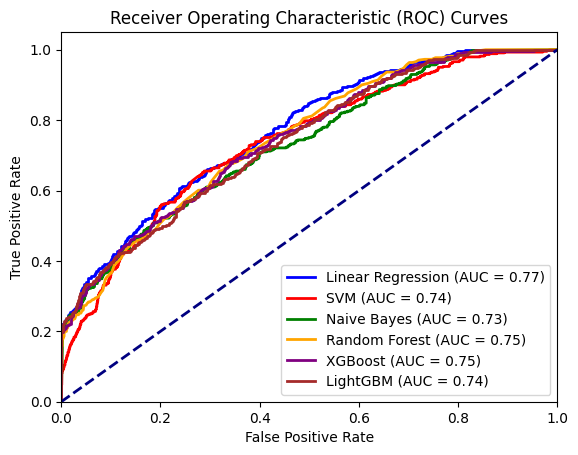

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 假设你已经有了以下模型的预测结果
# y_test 是测试集的真实标签
# y_pred_lr, y_pred_svm, y_pred_nb, y_pred_rf, y_pred_xgb, y_pred_lgb 是各个模型的预测概率

# 计算每个模型的 ROC 曲线和 AUC 值
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# 绘制所有模型的 ROC 曲线
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Linear Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label='Naive Bayes (AUC = %0.2f)' % roc_auc_nb)
plt.plot(fpr_rf, tpr_rf, color='orange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, color='purple', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_lgb, tpr_lgb, color='brown', lw=2, label='LightGBM (AUC = %0.2f)' % roc_auc_lgb)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# 机器学习可解释性分析

原则上挑选表现最好的模型，对其利用shap和pdpbox库进行可解释性分析

这里我们选取lightgbm模型进行可解释性分析，虽然他不是表现最好的，但是他计算速度最快，你可以说自己其实是对随机森林解释的，没有什么区别

In [64]:
# shap解释需要计算shap值，才可以后续可视化
import shap
import lightgbm as lgb

# 使用最佳参数重新训练一个新的 LightGBM 模型
best_params = {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 63}
lgb_best = lgb.LGBMClassifier(**best_params)
lgb_best.fit(X_train, y_train)

# 使用 shap 进行解释
# 创建一个 SHAP 解释器，使用训练好的 LightGBM 模型
explainer = shap.Explainer(lgb_best)

# 计算 SHAP 值，使用训练集
shap_values = explainer.shap_values(X_train)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4328, number of negative: 4328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 8656, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


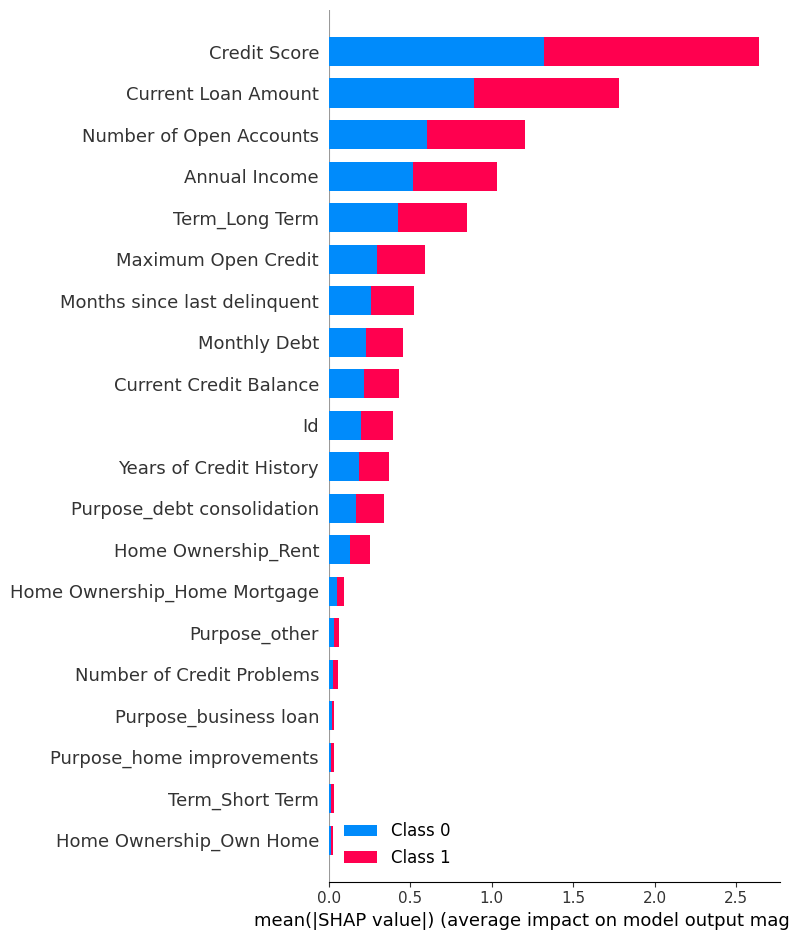

In [65]:
# 可视化所有类别的SHAP 汇总图
shap.summary_plot(shap_values, X_train)

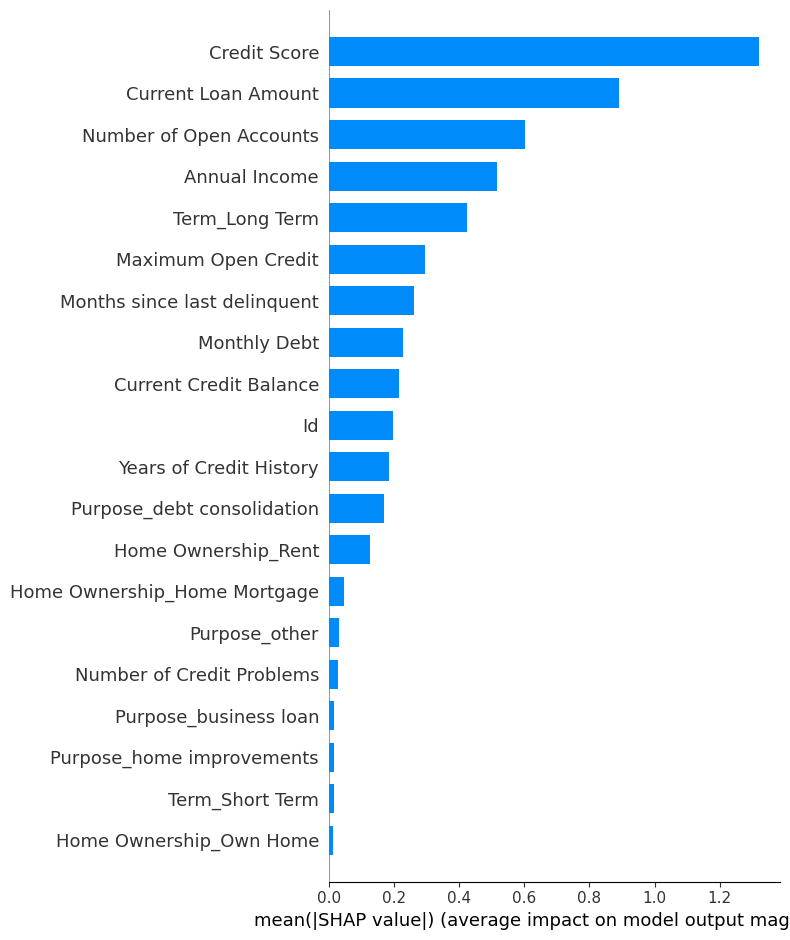

In [66]:
# SHAP 汇总图设置为条形图，可以显示特征重要性
shap.summary_plot(shap_values[1], X_train, plot_type="bar")

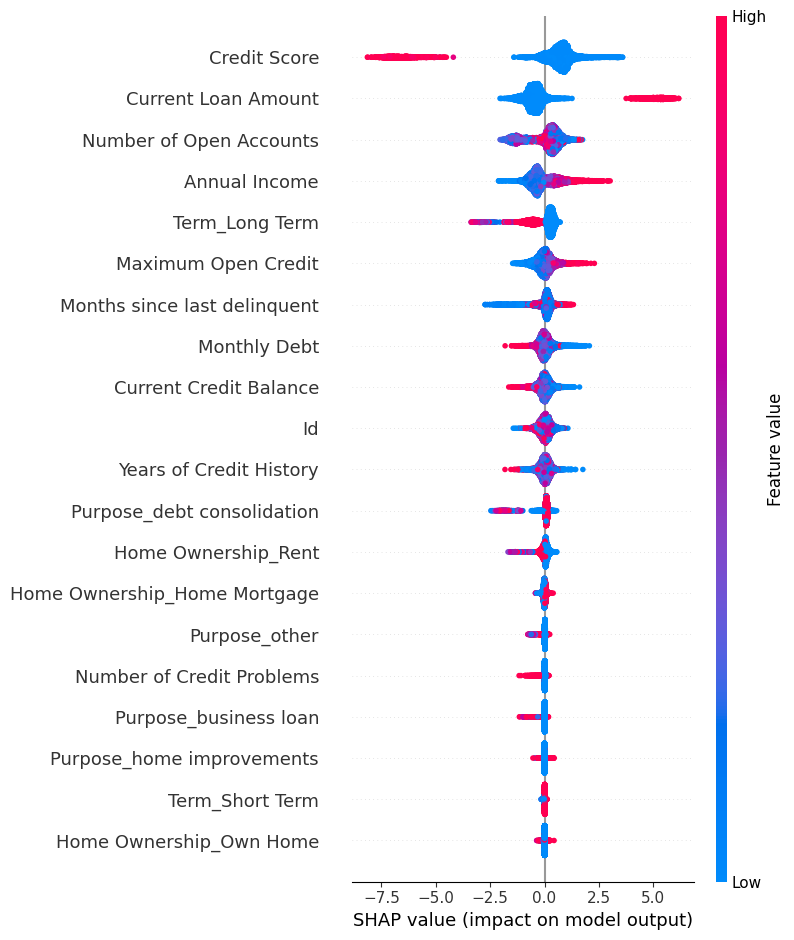

In [67]:
# SHAP 汇总图默认设置为点图，可以反应特征的重要性和影响方向
shap.summary_plot(shap_values[0], X_train,plot_type="dot")

In [68]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 970 to 2669
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            1500 non-null   float64
 1   Annual Income                 1500 non-null   float64
 2   Tax Liens                     1500 non-null   float64
 3   Number of Open Accounts       1500 non-null   float64
 4   Years of Credit History       1500 non-null   float64
 5   Maximum Open Credit           1500 non-null   float64
 6   Number of Credit Problems     1500 non-null   float64
 7   Months since last delinquent  1500 non-null   float64
 8   Bankruptcies                  1500 non-null   float64
 9   Current Loan Amount           1500 non-null   float64
 10  Current Credit Balance        1500 non-null   float64
 11  Monthly Debt                  1500 non-null   float64
 12  Credit Score                  1500 non-null   float64
 13  Home O

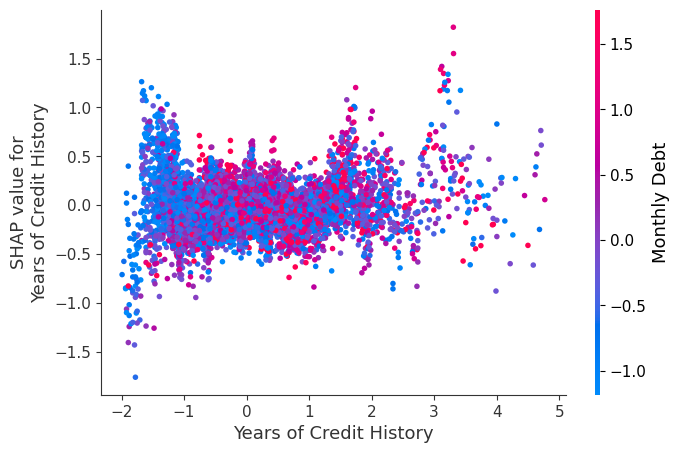

In [69]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Years of Credit History', shap_values[1], X_train, interaction_index="Monthly Debt")
# shap.dependence_plot('Tax Liens', shap_values[1], X_train, interaction_index="Annual Income")

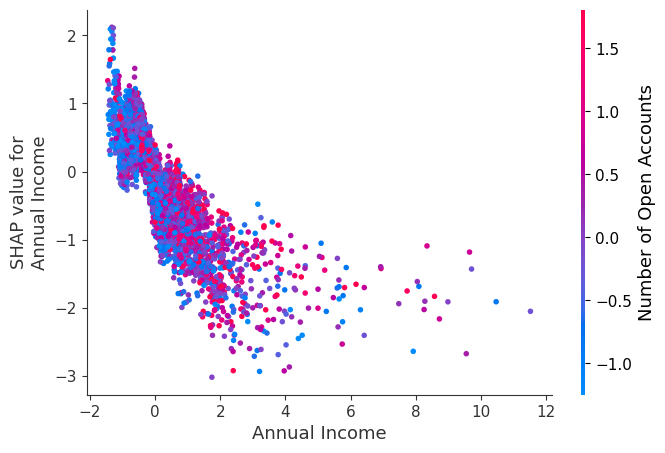

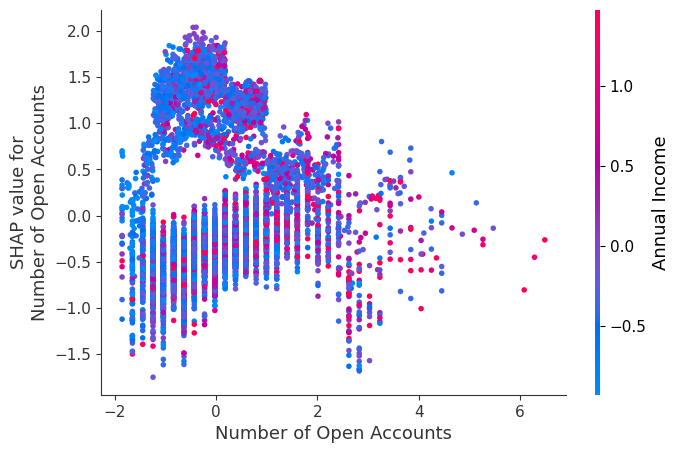

In [70]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Annual Income', shap_values[1], X_train, interaction_index="Number of Open Accounts")
shap.dependence_plot('Number of Open Accounts', shap_values[1], X_train, interaction_index="Annual Income")

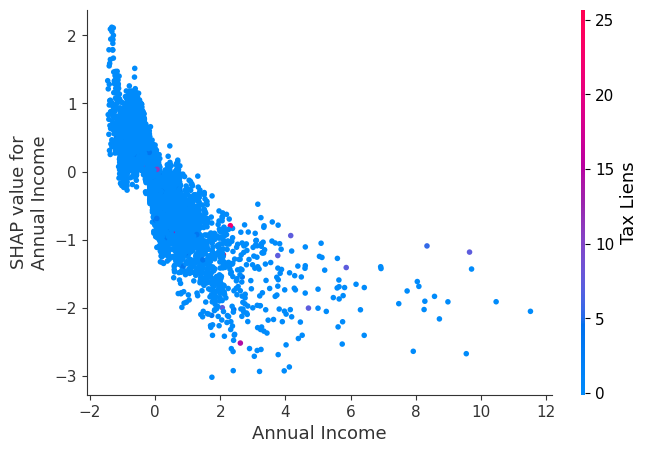

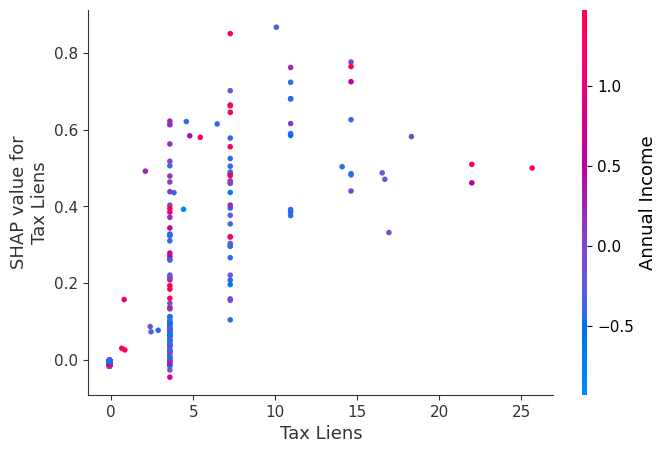

In [71]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Annual Income', shap_values[1], X_train, interaction_index="Tax Liens")
shap.dependence_plot('Tax Liens', shap_values[1], X_train, interaction_index="Annual Income")

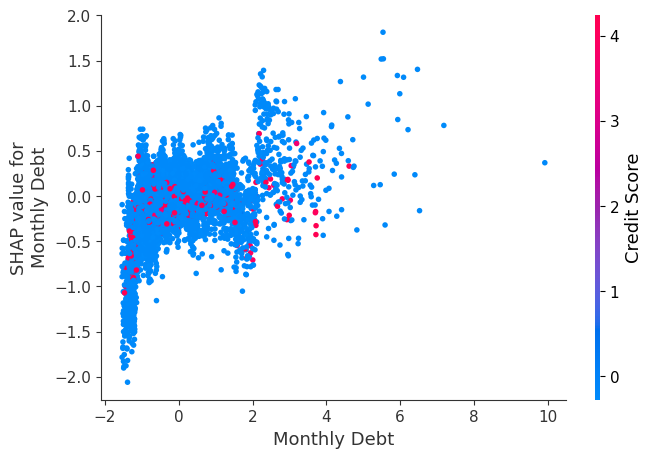

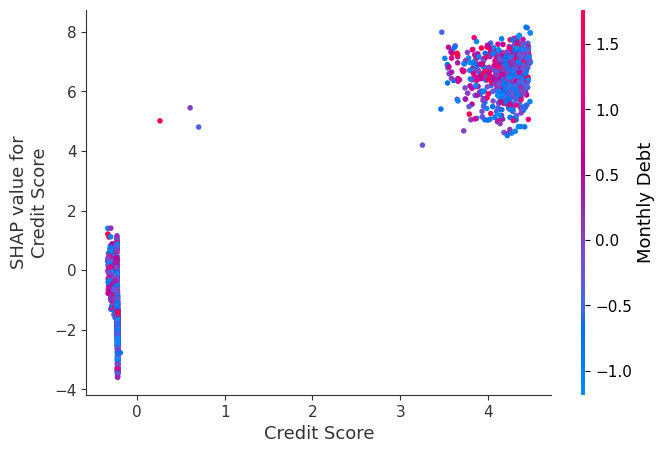

In [72]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Monthly Debt', shap_values[1], X_train, interaction_index="Credit Score")
shap.dependence_plot('Credit Score', shap_values[1], X_train, interaction_index="Monthly Debt")

In [73]:
# 绘制交互效应热力图
shap_interaction_values = explainer.shap_interaction_values(X_train)

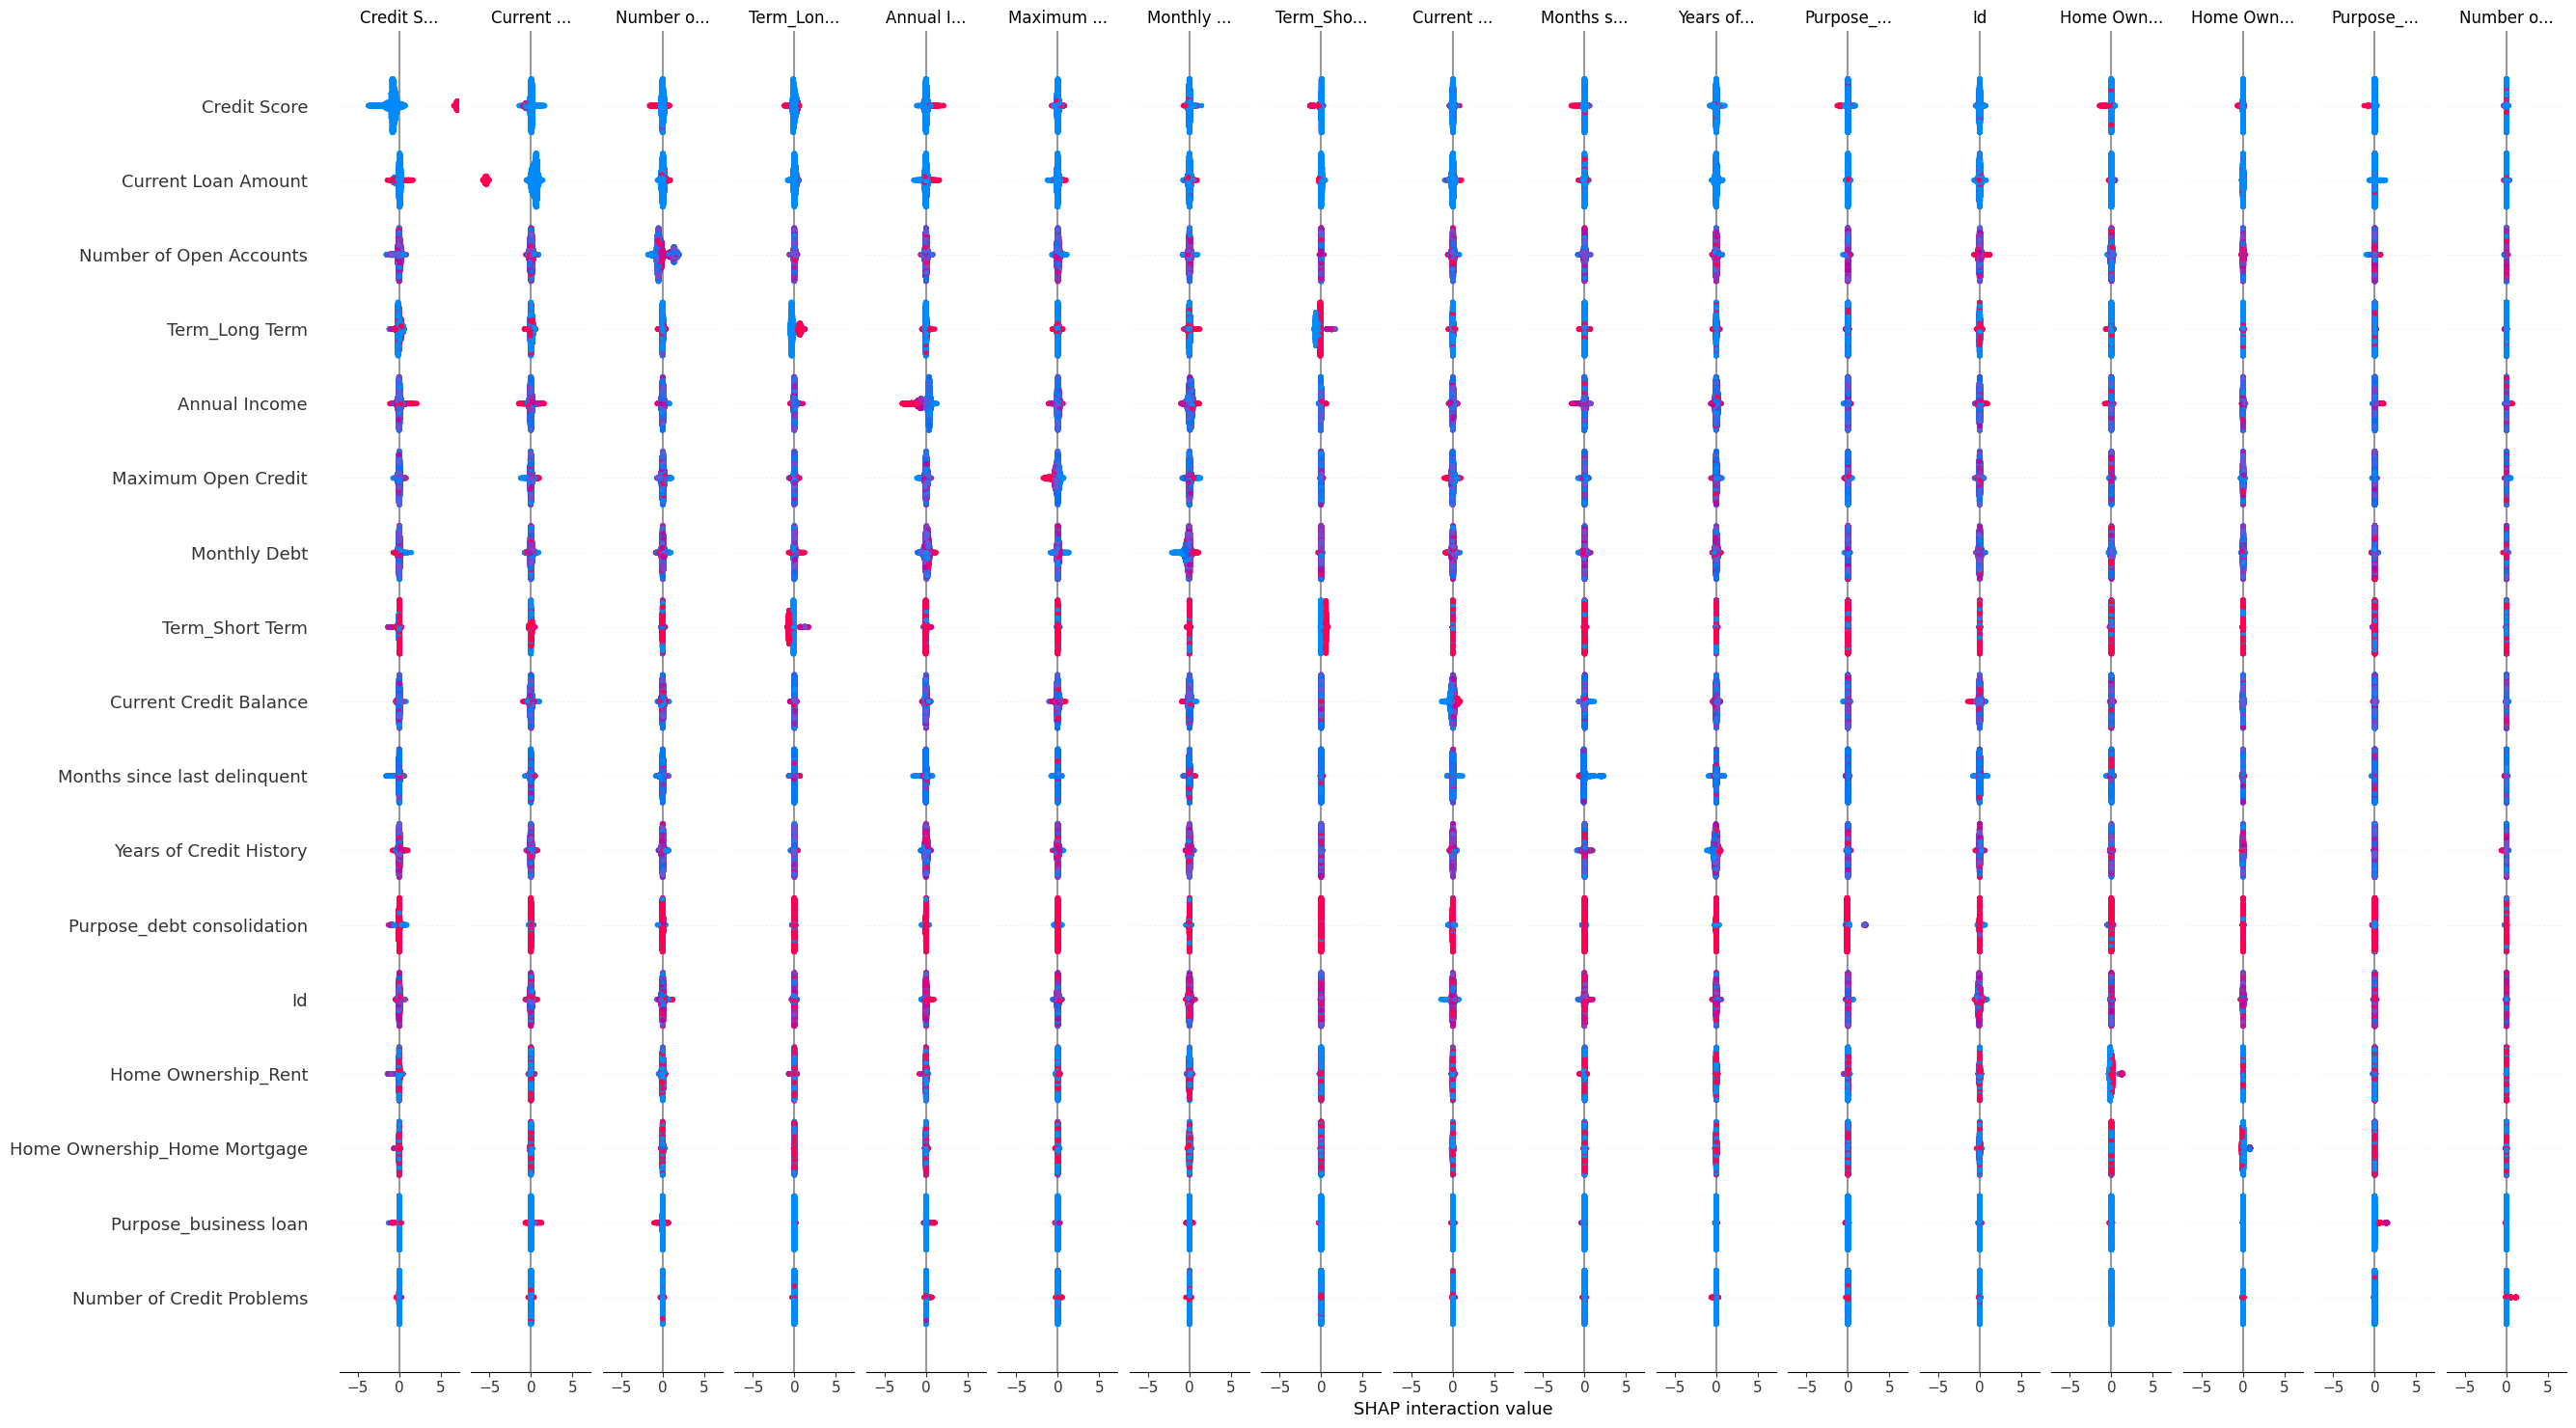

In [ ]:
# shap的交互是比较复杂的协同关系，并不是简单的相乘
# 可视化交互效应，max_display这个参数可以控制显示的特征数量，这个特征的顺序是重要度顺序
shap.summary_plot(shap_interaction_values, X_train, max_display=17)

# 如果分布在0附近，说明这个特征交互对模型的影响不大
# 如果分布在两端，说明这个特征交互对模型的影响很大